In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane import AngleEmbedding

In [2]:
dev = qml.device("default.qubit", wires=2)

In [3]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

#def rot(x):
    

def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [4]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):

    statepreparation(angles)
    return qml.expval(qml.PauliZ(0))


test(ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev.state))

x               :  [0.53896774 0.79503606 0.27826503 0.        ]
angles          :  [ 0.56397465 -0.          0.         -0.97504604  0.97504604]
amplitude vector:  [ 5.38967743e-01  7.95036065e-01  2.78265032e-01 -2.77555756e-17]


In [5]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [6]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [7]:
data = np.loadtxt("variational classifier/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print("First X sample (original)  :", X[0])

# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.3  0.  ]
First X sample (normalized): [0.44376016 0.83205029 0.33282012 0.        ]
First features sample      : [ 0.67858523 -0.          0.         -1.080839    1.080839  ]


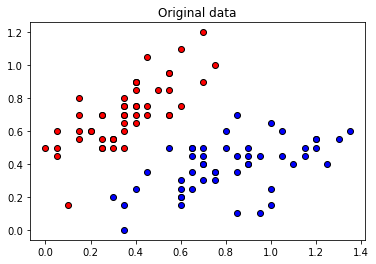

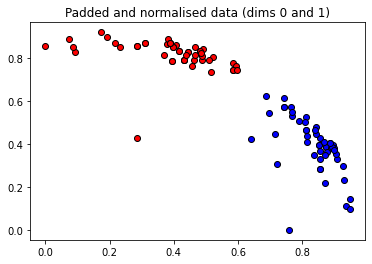

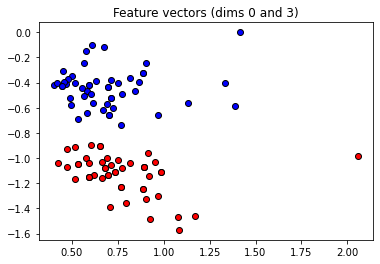

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

In [9]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [10]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [11]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [12]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [13]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [14]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.4490948 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.3312057 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.1589332 | Acc train: 0.4533333 | Acc validation: 0.5600000 
Iter:     4 | Cost: 0.9806934 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 0.8865623 | Acc train: 0.6133333 | Acc validation: 0.7600000 
Iter:     6 | Cost: 0.8580769 | Acc train: 0.6933333 | Acc validation: 0.7600000 
Iter:     7 | Cost: 0.8473132 | Acc train: 0.7200000 | Acc validation: 0.6800000 
Iter:     8 | Cost: 0.8177533 | Acc train: 0.7333333 | Acc validation: 0.6800000 
Iter:     9 | Cost: 0.8001100 | Acc train: 0.7466667 | Acc validation: 0.6800000 
Iter:    10 | Cost: 0.7681053 | Acc train: 0.8000000 | Acc validation: 0.7600000 
Iter:    11 | Cost: 0.7440015 | Acc train: 0.8133333 | Acc validation: 0.9600000 
Iter:    12 | Cost: 0.7583777 | Acc train: 0.6800000 | Acc validation: 0.7600000 
Iter:    13 | Co

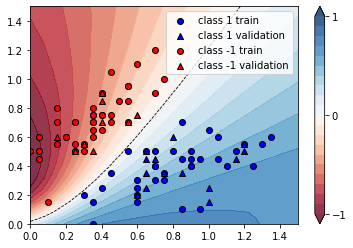

In [15]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(weights, bias, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()